1. INITIALIZATION

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2. LOADING DATASET

In [3]:
#  input to vgg16 is 224x224 with rgb, batch_size=32
IMAGE_SIZE=[224,224]
BATCH_SIZE=32

In [20]:
train_path='F:\\project\\Neurodegen\\Dataset\\Alz-DS\\data\\train'
test_path='F:\\project\\Neurodegen\\Dataset\\Alz-DS\\data\\test'

Importing VGG16 library and add preprocesing layer in front of the VGG16.

In [4]:
vgg16=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [5]:
for layers in vgg16.layers:
  print(layers)

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>


Setting layer.trainable to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training (either when training with fit() or when training with any custom loop that relies on trainable_weights to apply gradient updates).
for layer in vgg16.layers:
  layer.trainable=False

In [6]:
for layer in vgg16.layers:
  layer.trainable=False

In [7]:
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


Vgg16 Model Summary

In [8]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Building the Final Model

In [10]:
model = Sequential()

model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))

View the structure of final model

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Specifying the Cost and Optimization Methods

In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Using the Image Data Generator to import images from dataset

In [27]:
train_datagen= ImageDataGenerator(rescale=1./255,
                                  shear_range =0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
training_set=train_datagen.flow_from_directory(train_path,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')


Found 33984 images belonging to 4 classes.


In [29]:
test_set=test_datagen.flow_from_directory( test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 6400 images belonging to 4 classes.


In [30]:
len(training_set)

1062

Model Fitting

In [31]:
r= model.fit(
    training_set,
    validation_data=test_set,
    epochs=15,
    steps_per_epoch=len(training_set) // BATCH_SIZE,
    validation_steps=len(test_set) // BATCH_SIZE
)

Epoch 1/15


f:\project\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.6776 - loss: 0.7192 - val_accuracy: 0.7708 - val_loss: 0.6075
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.7287 - loss: 0.6324 - val_accuracy: 0.6719 - val_loss: 0.6995
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.6765 - loss: 0.6853 - val_accuracy: 0.7135 - val_loss: 0.6503
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.7417 - loss: 0.6458 - val_accuracy: 0.6979 - val_loss: 0.7164
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.7299 - loss: 0.5799 - val_accuracy: 0.6094 - val_loss: 0.8674
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.7171 - loss: 0.6302 - val_accuracy: 0.6927 - val_loss: 0.6552
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.7445 - loss: 0.5898 - val_accuracy: 0.7083 - val_loss: 0.6813
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 152s 5s/step - accuracy: 0.7378 - loss: 0.6237 - val_accuracy: 0.6667 - val_loss: 0.

Plotting the Losses

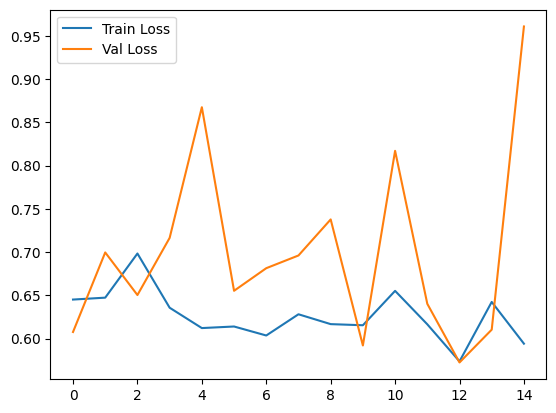

<Figure size 640x480 with 0 Axes>

In [33]:
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

Plotting Accuracy

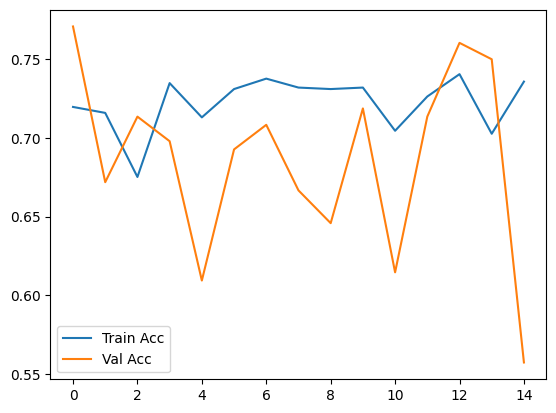

<Figure size 640x480 with 0 Axes>

In [34]:
plt.plot(r.history['accuracy'], label='Train Acc')
plt.plot(r.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

Predictions

In [35]:
from tensorflow.keras.models import load_model 
model.save('model_vgg16.h5')

In [36]:
y_pred=model.predict(test_set)

200/200 ━━━━━━━━━━━━━━━━━━━━ 934s 5s/step


In [37]:
y_pred

array([[1.0687007e-04, 3.8787284e-09, 9.9708349e-01, 2.8096044e-03],
       [1.9257157e-01, 9.9919758e-05, 5.5095112e-01, 2.5637740e-01],
       [5.0682750e-02, 1.9298295e-08, 8.4468329e-01, 1.0463396e-01],
       ...,
       [6.7257822e-01, 1.5578383e-06, 1.8558364e-01, 1.4183658e-01],
       [4.5914146e-01, 5.0506469e-07, 2.9587829e-01, 2.4497984e-01],
       [4.9025729e-01, 7.6538545e-06, 3.6345530e-01, 1.4627977e-01]],
      dtype=float32)

In [38]:
import numpy as np
y_pred=np.argmax(y_pred,axis=1)

In [39]:
y_pred

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [40]:
from tensorflow.keras.preprocessing import image

In [43]:
model=load_model('model_vgg16.h5')
img=image.load_img('F:\\project\\Neurodegen\\Dataset\\Alz-DS\\data\\test\\MildDemented\\27 (10).jpg',target_size=(224,224))

In [44]:
x=image.img_to_array(img)

In [46]:
Z=plt.imread('F:\\project\\Neurodegen\\Dataset\\Alz-DS\\data\\test\\MildDemented\\27 (10).jpg')

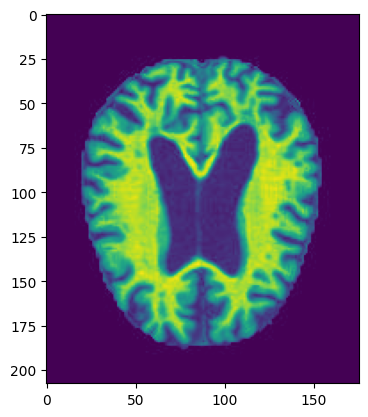

In [47]:
plt.imshow(Z)

In [48]:
x.shape

(224, 224, 3)

In [49]:
x=x/255

In [50]:
from keras.applications.vgg16 import preprocess_input

In [51]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [52]:
model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


array([[0.8683791 , 0.02688118, 0.07983065, 0.02490914]], dtype=float32)

In [53]:
result=np.argmax(model.predict(img_data),axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


In [54]:
result

array([0], dtype=int64)